# Домашнее задание - линейная регрессия

### Работа с признаками (8 баллов)

Скачайте датасет из материалов к уроку или по ссылке https://raw.githubusercontent.com/jupiterzhuo/travel-insurance/master/travel%20insurance.csv 


Описание признаков:

* Agency — название страхового агентства
* Agency Type — тип страхового агентства
* Distribution Channel — канал продвижения страхового агентства
* Product Name — название страхового продукта
* Duration — длительность поездки (количество дней)
* Destination — направление поездки
* Net Sales — сумма продаж 
* Commission (in value) — комиссия страхового агентства
* Gender — пол застрахованного
* Age — возраст застрахованного

Ответ:
* Claim — потребовалась ли страховая выплата: «да» — 1, «нет» — 0

Обработайте пропущенные значения и примените написанные функции onehot_encode() и minmax_scale().

**Подсказка**: маску для категориальных признаков можно сделать фильтром cat_features_mask = (df.dtypes == "object").values

In [715]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [698]:
def onehot_encoding(x):
    u = np.unique(x)
    y = np.zeros([x.shape[0], u.shape[0]], int)
    for i in range(len(x)):
        y[i][np.where(u == x[i])[0][0]] = 1
    return y

In [699]:
def minmax_scale(x):
    if np.all(x == x[0]):
        return np.zeros_like(x, float)
    return (x - x.min(axis=0)) / (x.max(axis=0) - x.min(axis=0))

In [700]:
df = pd.read_csv('travel insurance.csv')

df['Claim'] = np.where(df['Claim'] == 'Yes', 1, 0)
df['Distribution Channel'] = np.where(df['Distribution Channel'] == 'Online', 1, 0)
df['Agency Type'] = np.where(df['Agency Type'] == 'Airlines', 1, 0)
df['Age'] = minmax_scale(df['Age'])

df = df[df['Net Sales'] >= 0]
df['Net Sales'] = minmax_scale(df['Net Sales'].to_numpy())  # Net Sales < 0??
df = df[df['Duration'] >= 0]  # Duration < 0??
df['Gender'][df['Gender'].isna()] = 'NB'

Подробный анализ и подготовка датасета часто помогают улучшить качество модели. Ниже представлено несколько идей преобразований. Вы можете применить одно или несколько из этих преобразований (а можете не применять), чтобы помочь будущей модели.

1. Посмотрите на количественные признаки. Возможно, в некоторых признаках есть выбросы - значения, которые сильно выбиваются. Такие значения полезно удалять. Советуем присмотреться к колонке Duration)

2. Можно заметить, что one hot encoding сильно раздувает количество столбцов. Радикальное решение - можно попробовать выбросить все категориальные признаки из датасета.

3. Если все-таки оставляете категориальные признаки, то подумайте, как уменьшить количество столбцов после one hot encoding. Признаки с большим количеством значений (Duration - 149! разных стран) можно удалить или попробовать сгруппировать некоторые значения.

4. Downsampling. Датасет достаточно большой, разница в классах огромная. Можно уменьшить число наблюдений с частым ответом.

In [701]:
# много "мусора"
agencyy = (df['Agency'].value_counts() / len(df['Agency'])) >= 0.01
df = df[df['Agency'].isin(agencyy[agencyy].index)]

In [702]:
dest = (df.Destination.value_counts() / len(df.Destination)) >= 0.01
df = df[df.Destination.isin(dest[dest].index)]

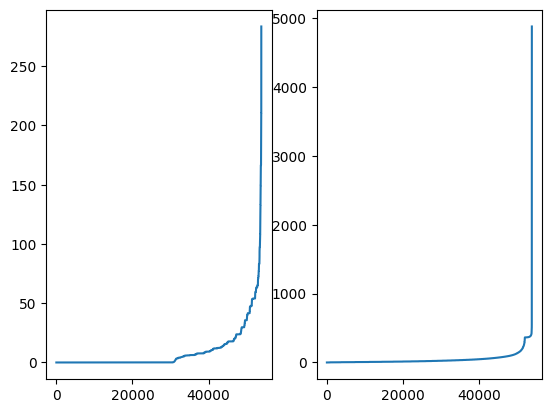

In [703]:
# отбросим выбросы в Duration и Commission
com = df['Commision (in value)'].to_numpy()
plt.subplot(121)
plt.plot(np.sort(com))

dur = df['Duration'].to_numpy()
plt.subplot(122)
plt.plot(np.sort(dur))

In [704]:
df = df[df['Duration'] < 4000]
df['Duration'] = minmax_scale(df['Duration'].to_numpy())

df = df[df['Commision (in value)'] < 200]
df['Commision (in value)'] = minmax_scale(df['Commision (in value)'].to_numpy())

In [705]:
# one hot encoding
res = onehot_encoding(df['Agency'].to_numpy())
res = np.c_[res, df['Agency Type'], df['Distribution Channel']]
res = np.c_[res, onehot_encoding(df['Product Name'].to_numpy())]
res = np.c_[res, df['Duration']]
res = np.c_[res, onehot_encoding(df['Destination'].to_numpy())]
res = np.c_[res, df['Net Sales'], df['Commision (in value)']]
res = np.c_[res, onehot_encoding(df['Gender'].to_numpy())]
res = np.c_[np.ones(res.shape[0]), res] # единички
res

array([[1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       [1., 1., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 1., 0., 0.]])

### Применение линейной регрессии (10 баллов)

Это задача классификации, но её можно решить с помощью линейной регрессии, если округлять предсказанный ответ до целого и выбирать ближайший по значению ответ из множества {0, 1}.

Вынесите признак 'Claim' в вектор ответов и разделите датасет на обучающую и тестовую выборку в соотношении 80 к 20. Зафиксируйте random_state.

**Подсказка:** быстро перевести Yes/No в 1/0 можно так - np.where(df['Claim'] == 'Yes', 1,0)

In [706]:
train_x, test_x, train_y, test_y = train_test_split(res, df['Claim'].to_numpy(), train_size=0.8, random_state=1)

Найдите аналитическое решение для обучающей выборки: обычное и регуляризацией l2. 

In [729]:
# посчитайте аналитическое решение
w = np.linalg.inv(train_x.T.dot(train_x)).dot(train_x.T).dot(train_y)

In [737]:
# посчитать аналитическое решение с регуляризацией
l = 1
w_l2 = np.linalg.inv(train_x.T.dot(train_x) + l ** 2 * np.eye(train_x.shape[1], train_x.shape[1])).dot(train_x.T).dot(train_y)

Постройте модель LinearRegression, примените к тестовой выборке и посчитайте MSE (можно использовать библиотеку sklearn)

In [727]:
from sklearn.linear_model import LinearRegression

# обучите модель линейной регрессии LinearRegression на обучающей выборке, примените к тестовой
a = LinearRegression(fit_intercept=True)
a.fit(train_x, train_y)

In [763]:
# посчитайте MSE, предварительно округлив предсказанные ответы до целого

pred_default = np.sum(test_x * w, axis=1).round(0)
pred_l2 = np.sum(test_x * w_l2, axis=1).round(0)

mse_default = mean_squared_error(test_y, pred_default)
mse_l2 = mean_squared_error(test_y, pred_l2)
mse_sk = mean_squared_error(test_y, a.predict(test_x))
print('MSE (without regularization):\t', round(mse_default, 4))
print('MSE (L2):\t\t\t\t\t\t', round(mse_l2, 4))
print('MSE (sklearn):\t\t\t\t\t', round(mse_sk, 4))

MSE (without regularization):	 0.1537
MSE (L2):						 0.015
MSE (sklearn):					 0.014


### Вывод (1 балла)

Напишите краткий вывод по заданию (достаточно пары предложений). Расскажите, какие способы предобработки данных вы выбрали и почему. Насколько хороша ваша модель?

Вначале я обратил внимание на пропуски в столбце Gender. Я решил сделать NaN категорией, чтобы не терять много данныъ
Потом я заметил выбросы в Duration и Commission и отбросил нелогичные значения Duration (< 0)
Кроме того я оставил только популярные Agency и Destination категории

Я заметил что моя default модель выдает значения вне диапазона [0;1], но я не знаю как это преобразовать/исправить